## Bacteria amount and growth rate prediction

The dataset contains results from a set of experiments where bacteria of different strains and under different conditions (CO2 availability, light, etc..) were grown to compute a growth curve for the bacteria - represented by the variables 'a' and 'mu'.

The CSV contains 7 fields as follows:

| variable | description |
|-----|------|
| n_cyanos | The number of Cyanobacteria available at the start |
| co2 | The amount of CO2 available |
| light | The amount of light available |
| SucRatio | How good the bacteria is at producing sucrose |
| Nsample | Experiment number |
| a | Maximum number of bacteria seen (Target variable) |
| mu | Growth rate of bacteria (Target variable) |


This pipeline involves exploratory data analysis, data normalisation, hyperparameter tuning, and experimenting with different models and methods to achieve the best results.

Inspecting the values from the dataset

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
%matplotlib inline

bacteria_data = pd.read_csv('fitting-results2.csv')
bacteria_data.head()

,n_cyanos,co2,light,SucRatio,Nsample,a,mu
0,262,73.578860,0.367894,0.451505,13123,5.033993,5.483011
1,610,74.582194,0.481606,0.969900,12474,1.018406,1.830727
2,118,33.111037,0.625418,0.909699,8867,2.569159,3.330662
3,159,8.027676,0.575251,0.137124,16494,1.837341,3.371570
4,957,38.796599,0.939799,0.234114,10267,0.999268,2.059303


Creating a profiling report for a thorough analysis

In [2]:
profile = ProfileReport(bacteria_data, title="Bacteria Profiling Report")
profile.to_file("bacteria_profiling_report.html")

/Users/sirderyl/opt/anaconda3/envs/.conda/lib/python3.10/site-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

As the 'Nsample' column is just the experiment number, which means every value is unique, it should be dropped from the dataset. It does not add anything of value for the model

In [3]:
unique_percentage = bacteria_data['Nsample'].nunique() / len(bacteria_data) * 100
print(f"Unique Nsample values: {unique_percentage:.2f}%")

Unique Nsample values: 100.00%


In [31]:
bacteria_data = bacteria_data.drop(columns=['Nsample'])

The correlation matrix shows that 'a' and 'mu' are almost perfectly correlated. 'n_cyanos' is an important variable as it has a high negative correlation with both 'a' and 'mu'. On the oposite end, 'light' has very weak correlation with all other variables.

          n_cyanos       co2     light  SucRatio         a        mu
n_cyanos  1.000000  0.001203 -0.023443  0.006291 -0.444273 -0.442704
co2       0.001203  1.000000 -0.002829  0.000193  0.209350  0.209381
light    -0.023443 -0.002829  1.000000 -0.015138  0.008905  0.011367
SucRatio  0.006291  0.000193 -0.015138  1.000000 -0.195975 -0.231578
a        -0.444273  0.209350  0.008905 -0.195975  1.000000  0.996551
mu       -0.442704  0.209381  0.011367 -0.231578  0.996551  1.000000


<Axes: >

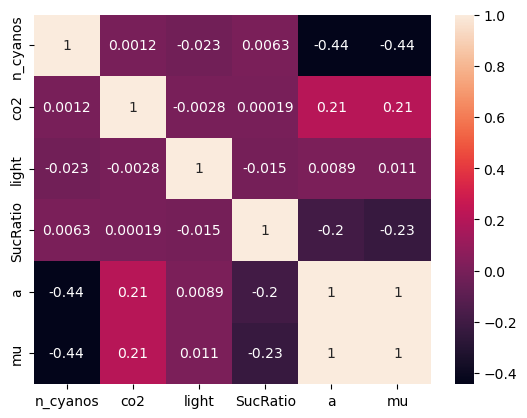

In [7]:
import seaborn as sns

corr_matrix = bacteria_data.corr()
print(corr_matrix)
sns.heatmap(data=corr_matrix, annot=True)

Inspecting the target variables in more detail:

Both 'a' and 'mu' have a skewed distribution, outliers and are positevely correlated to each other. The large range of outliers can have a negative impact on the model's generalization ability.

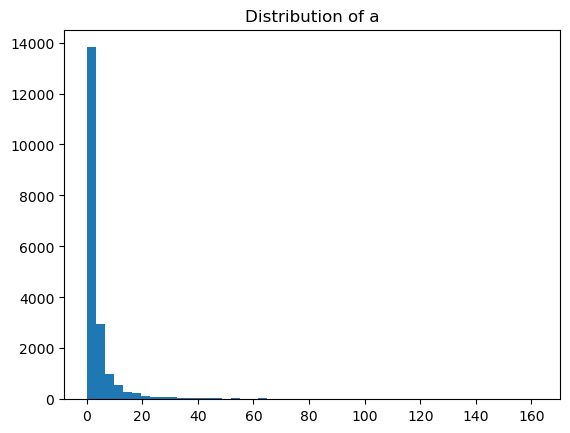

In [5]:
plt.figure()
plt.hist(bacteria_data['a'], bins=50)
plt.title('Distribution of a')
plt.show()

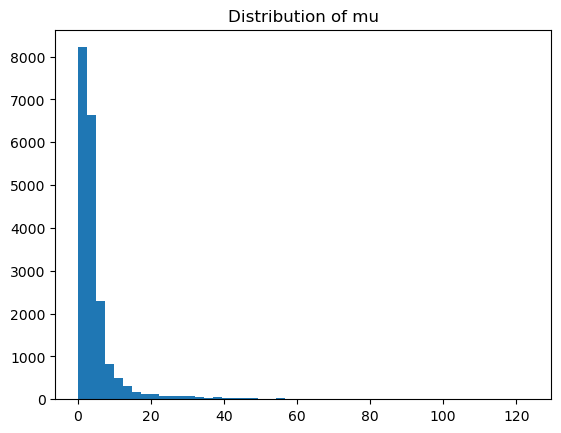

In [32]:
plt.figure()
plt.hist(bacteria_data['mu'], bins=50)
plt.title('Distribution of mu')
plt.show()

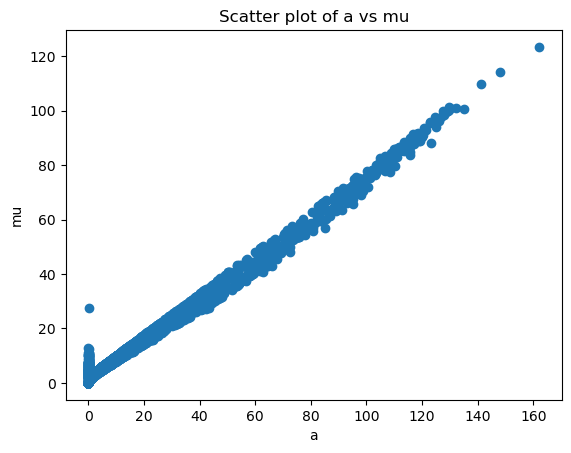

In [6]:
plt.figure()
plt.scatter(bacteria_data['a'], bacteria_data['mu'])
plt.xlabel('a')
plt.ylabel('mu')
plt.title('Scatter plot of a vs mu')
plt.show()

Applying the natural logarithm to 1 + x for each value in 'a' and 'mu' to address the skewness. This makes the distribution closer to Gaussian, which improves the algorithm's performance

In [33]:
bacteria_data['log_a'] = np.log1p(bacteria_data['a'])
bacteria_data['log_mu'] = np.log1p(bacteria_data['mu'])

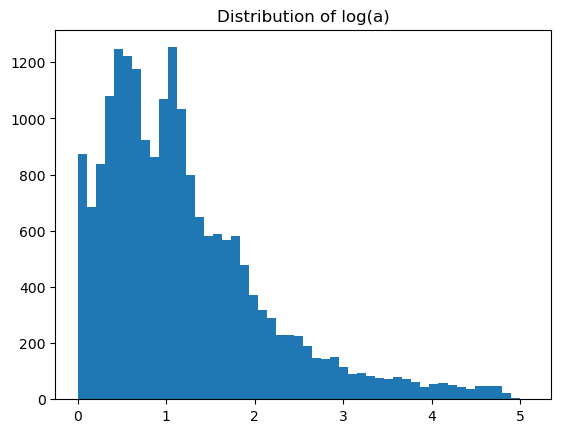

In [9]:
plt.figure()
plt.hist(bacteria_data['log_a'], bins=50)
plt.title('Distribution of log(a)')
plt.show()

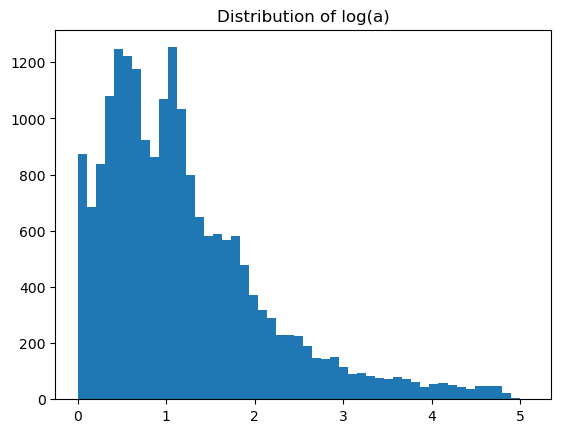

In [ ]:
plt.figure()
plt.hist(bacteria_data['log_mu'], bins=50)
plt.title('Distribution of log(mu)')
plt.show()

Creating X and y variables, using the 'corrected' target variables

In [37]:
X = bacteria_data.drop(columns=['a', 'mu', 'log_a', 'log_mu'])
y_a = bacteria_data['log_a']
y_mu = bacteria_data['log_mu']

Splitting the data into train/test (80%/20%) for both target variables, will be applying 5-fold cross validation for the training

In [11]:
from sklearn.model_selection import train_test_split

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_a, test_size=0.2, random_state=42)
X_train_mu, X_test_mu, y_train_mu, y_test_mu = train_test_split(X, y_mu, test_size=0.2, random_state=42)

Scaling the training and testing data

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_a_scaled = scaler.fit_transform(X_train_a)
X_test_a_scaled = scaler.transform(X_test_a)

X_train_mu_scaled = scaler.fit_transform(X_train_mu)
X_test_mu_scaled = scaler.transform(X_test_mu)

A function that uses the trained models to make predictions using the test data, prints out the evaluation metrics, and displays a scatter plot comparing ground truth values with predicted values

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(X_test, y_test, model, pred_class):
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Performance Metrics:")
    print(f"R2 Score: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    y_true_np = np.array(y_test)
    y_pred_np = np.array(y_pred)
    explained_variance = np.var(y_pred_np) / np.var(y_true_np)

    print(f"Explained Variance Ratio: {explained_variance:.4f}")

    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f"{model.__class__.__name__} Predictions vs True Values for {pred_class}")
    plt.show()

Defining the hyper-parameter combinations for the SVR and Random Forest pipelines

In [14]:
params_svr = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

params_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

Training an SVR model on 'a' while tuning the hyper-parameters using grid search with 5-fold cross validation. The scoring determines the training will focus on minimising the mean squared error

In [15]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_a = GridSearchCV(SVR(), params_svr, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
svr_a.fit(X_train_a_scaled, y_train_a)

print(f"Best parameters for model a (SVR): {svr_a.best_params_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 5/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.261 total time=  49.4s
[CV 4/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.252 total time=  49.5s
[CV 1/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.234 total time=  49.7s
[CV 3/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.237 total time=  49.7s
[CV 2/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.239 total time=  49.7s
[CV 1/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.223 total time=  52.3s
[CV 2/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.230 total time=  52.5s
[CV 3/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.211 total time=  52.6s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=rbf;, score=-0.046 total time=  15.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=rbf;, score=-0.044 total time=  15.4s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=rbf;, score=-0.050 total time=  15.4s
[CV 4/5] END ...C=0.1, gamma=scale, kernel=rbf;

Evaluating the model's performance, printing out the metrics, and displaying the scatter plot

Performance Metrics:
R2 Score: 0.9827
MSE: 0.0153
RMSE: 0.1237
MAE: 0.0610
Explained Variance Ratio: 0.9568


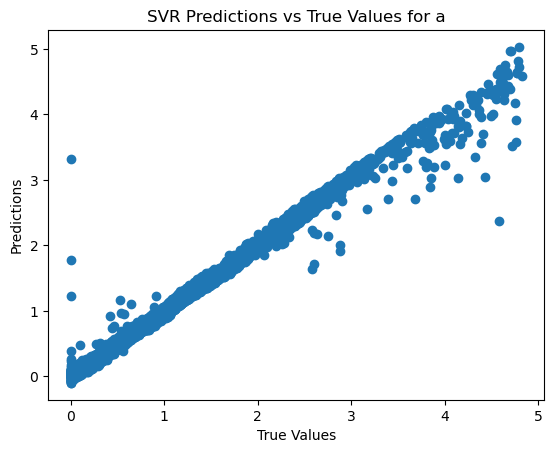

In [23]:
evaluate(X_test_a_scaled, y_test_a, svr_a.best_estimator_, 'a')

Training the SVR model on 'mu' in a similar fashion

In [24]:
svr_mu = GridSearchCV(SVR(), params_svr, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
svr_mu.fit(X_train_mu_scaled, y_train_mu)

print(f"Best parameters for model mu (SVR): {svr_mu.best_params_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 4/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.188 total time=  40.2s
[CV 2/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.181 total time=  40.2s
[CV 5/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.189 total time=  40.3s
[CV 3/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.180 total time=  40.5s
[CV 1/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.172 total time=  40.7s
[CV 2/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.169 total time=  41.0s
[CV 1/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.159 total time=  41.1s
[CV 3/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.161 total time=  41.3s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=rbf;, score=-0.052 total time=  13.4s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=rbf;, score=-0.060 total time=  13.4s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=rbf;, score=-0.060 total time=  13.3s
[CV 4/5] END ...C=0.1, gamma=scale, kernel=rbf;

Performance Metrics:
R2 Score: 0.9227
MSE: 0.0375
RMSE: 0.1936
MAE: 0.0845
Explained Variance Ratio: 0.8817


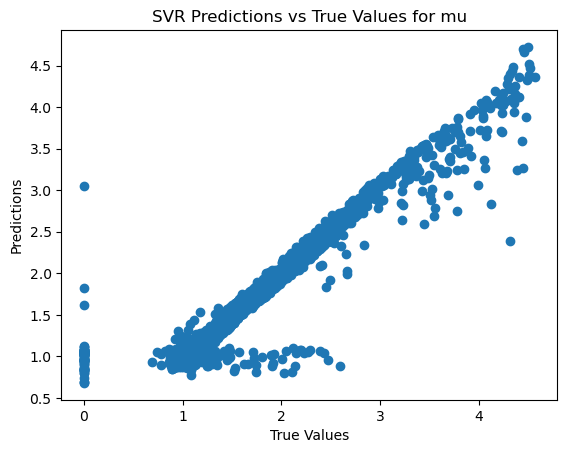

In [25]:
evaluate(X_test_mu_scaled, y_test_mu, svr_mu.best_estimator_, 'mu')

Training a Random Forest model on 'a' using the same strategy

In [26]:
from sklearn.ensemble import RandomForestRegressor

model_a = GridSearchCV(RandomForestRegressor(), params_rf, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
model_a.fit(X_train_a_scaled, y_train_a)

print(f"Best parameters for model a: {model_a.best_params_}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 5/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.005 total time=   8.9s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.006 total time=   9.0s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.004 total time=   9.0s
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.005 total time=   9.1s
[CV 4/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.006 total time=   9.1s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=-0.004 total time=  21.5s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=-0.006 total time=  21.6s
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=-0.005 total time=  21.5s
[CV 4/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=-0.006 total time=  21.8s
[CV 5/5] END max_depth=None, 

Performance Metrics:
R2 Score: 0.9936
MSE: 0.0057
RMSE: 0.0754
MAE: 0.0271
Explained Variance Ratio: 0.9859


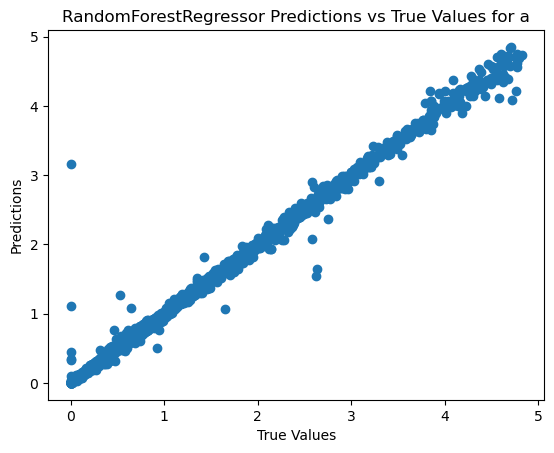

In [27]:
evaluate(X_test_a_scaled, y_test_a, model_a.best_estimator_, 'a')

Training a Random Forest model on 'mu'

In [28]:
model_mu = GridSearchCV(RandomForestRegressor(), params_rf, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
model_mu.fit(X_train_mu_scaled, y_train_mu)

print(f"Best parameters for model mu: {model_mu.best_params_}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 5/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.010 total time=  11.5s
[CV 4/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.015 total time=  11.5s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.011 total time=  11.5s
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.009 total time=  11.6s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=-0.012 total time=  11.6s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=-0.010 total time=  20.0s
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=-0.009 total time=  20.1s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=-0.012 total time=  20.1s
[CV 4/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=-0.015 total time=  16.6s
[CV 5/5] END max_depth=None, 

Performance Metrics:
R2 Score: 0.9781
MSE: 0.0106
RMSE: 0.1030
MAE: 0.0378
Explained Variance Ratio: 0.9707


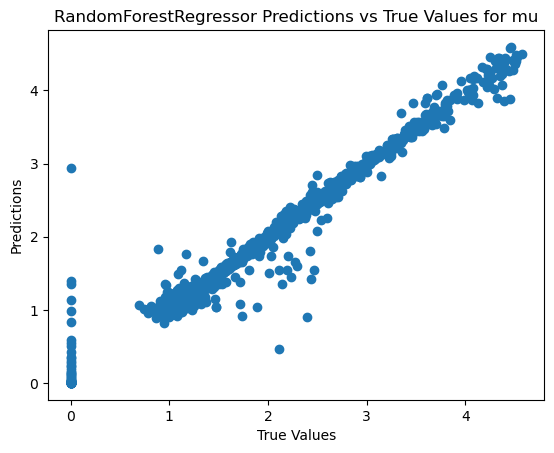

In [29]:
evaluate(X_test_mu_scaled, y_test_mu, model_mu.best_estimator_, 'mu')

Comparison of the results:

| Model | R2 Score | MSE | RMSE | MAE | EVR |
| ----- | -------- | --- | ---- | --- | --- |
| SVR (a) | 0.9827 | 0.0153 | 0.1237 | 0.0610 | 0.9568 |
| Random Forest (a) | 0.9936 | 0.0057 | 0.0754 | 0.0271 | 0.9859 |
| SVR (mu) | 0.9227 | 0.0375 | 0.1936 | 0.0845 | 0.8817 |
| Random Forest (mu) | 0.9781 | 0.0106 | 0.1030 | 0.0378 | 0.9707 |

Evaluation:

The current preprocessing pipeline with Random Forest algorithm produced the best results. I also experimented with training the models on the original target classes (without skewness modifications), removing the outliers of the target classes using interquartile range, and applying PCA (retaining 99% of the variance). None of these (or combinations of these) produced better results.

Analysis:

Random Forest outperforms SVR in all metrics. The higher R2 score indicates better fit, and lower error scores indicate a better accuracy.

RF shows better performance, likely due to its ability to capture complex, non-linear relationships and interactions in the data. While the RBF kernel for SVR can handle non-linearity as well, it might not capture complex interactions as effectively. SVR woule require explicit feature engineering to capture these interactions, which is not as effective. Also, Random Forest is more robust to outliers due to averaging acroess multiple trees and it handles high-dimensional data well due to its ability to select important features.

Further improvements could be made by fine-tuning hyperparameters or exploring additional features.